### Intro
This notebook shows how to deal with missing data by introducing a set of latent variables in the model. You will learn that this approach allows you to extract some information even from imperfect dataset points.<br>
(We don't discuss the details of inference methods)

### Load packages

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pandas as pd

### Synthetic data generation
You will create a set of two linear models which will be assumed as the ground-truth. You will generate a synthetic dataset with these models and perform Bayesian linear regression with the dataset. You will compare the ground-truth model coefficients and the posterior distribution.

In [20]:
np.random.seed(1234)
def f(x,w):
    """
    This is a linear function you use to generate data
    x: input, size N x 1 where N means the number of data points
    w: model parameters (coefficient), size 2 x 1
    """
    N = x.shape[0]
    x = np.concatenate((x[:,None], np.ones((N,1))), axis=1)
    return np.dot(x,w)

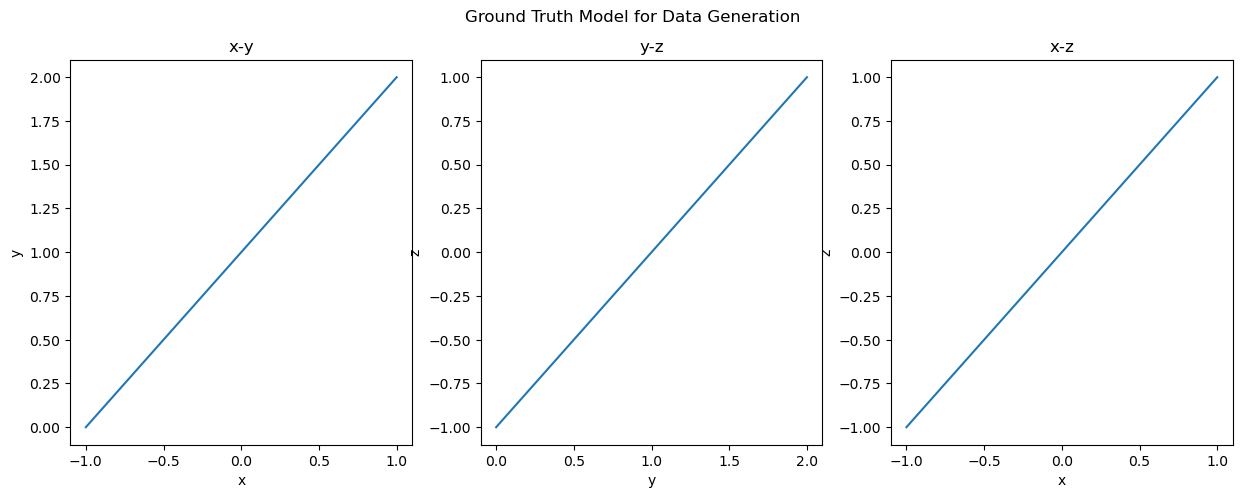

In [23]:
# Ground-truth model coefficient
w1_grd = np.array((1,1))[:,None]
w2_grd = np.array((1,-1))[:,None]

x_plt = np.linspace(-1,1,50)
y_plt = f(x_plt,w1_grd).flatten()
z_plt = f(y_grd,w2_grd).flatten()

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Ground Truth Model for Data Generation')
ax[0].plot(x_plt,y_plt)
ax[0].set_ylabel('y')
ax[0].set_xlabel('x')
ax[0].set_title('x-y')
ax[1].plot(y_grd,z_plt)
ax[1].set_ylabel('z')
ax[1].set_xlabel('y')
ax[1].set_title('y-z')
ax[2].plot(x_plt,z_plt)
ax[2].set_ylabel('z')
ax[2].set_xlabel('x')
ax[2].set_title('x-z')
plt.show()

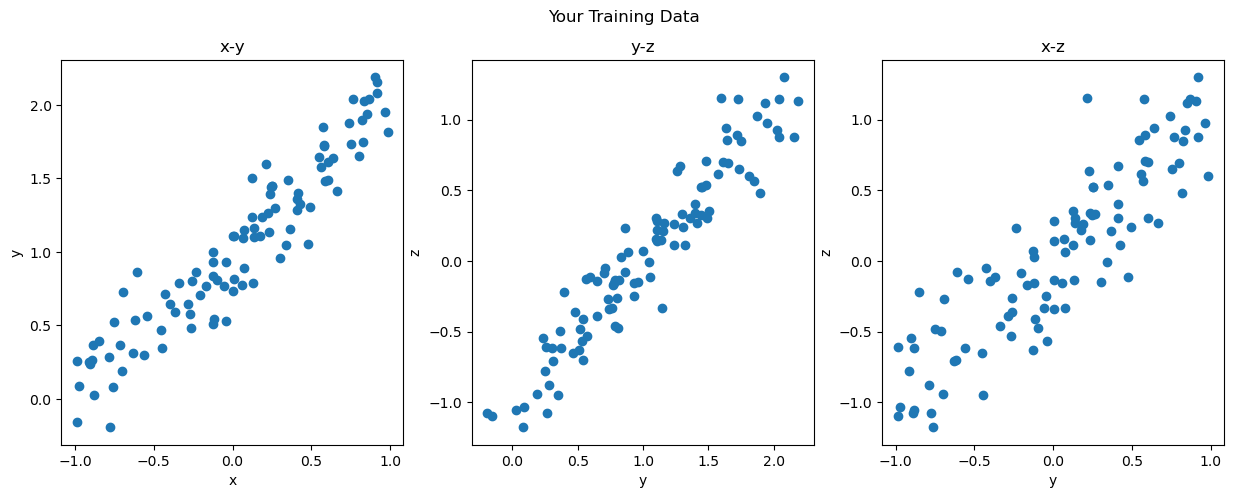

In [24]:
# Data generation with the ground truth model
N_data = 100 # number of datapoints
# Your training dataset
x_data = np.random.rand(N_data)*2-1
y_data = (f(x_data,w1_grd)+np.random.randn(N_data,1)*0.2).flatten()
z_data = (f(y_data,w2_grd)+np.random.randn(N_data,1)*0.2).flatten()
DF = pd.DataFrame({'x':x_data.flatten(),
                   'y':y_data.flatten(),
                   'z':z_data.flatten()})

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Your Training Data')
ax[0].scatter(x_data,y_data)
ax[0].set_ylabel('y')
ax[0].set_xlabel('x')
ax[0].set_title('x-y')
ax[1].scatter(y_data,z_data)
ax[1].set_ylabel('z')
ax[1].set_xlabel('y')
ax[1].set_title('y-z')
ax[2].scatter(x_data,z_data)
ax[2].set_ylabel('z')
ax[2].set_xlabel('y')
ax[2].set_title('x-z')
plt.show()

In [25]:
DF

,x,y,z
0,-0.616961,0.536513,-0.702592
1,0.244218,1.441202,0.322829
2,-0.124545,0.929623,-0.153278
3,0.570717,1.849114,0.563955
4,0.559952,1.575920,0.617799
...,...,...,...
95,0.005119,0.735613,-0.339275
96,0.073756,1.146469,-0.333031
97,0.638404,1.635454,0.943660
98,-0.885769,0.368710,-0.618673


### Bayesian modelling with the complete dataset

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w1, w2]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 46 seconds.


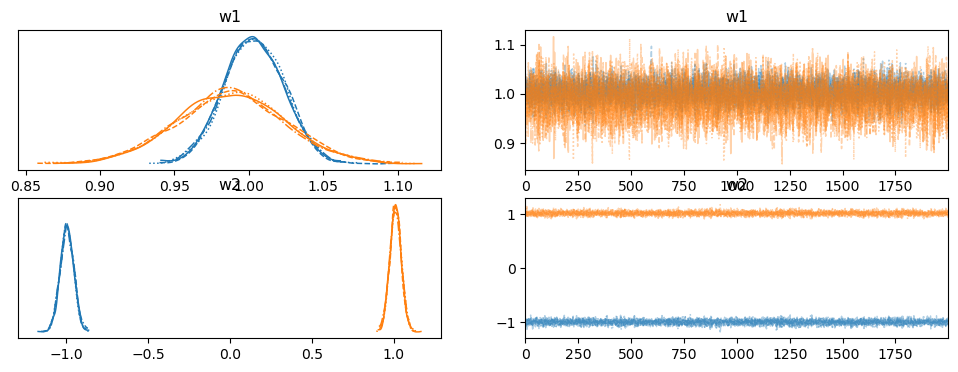

In [6]:
with pm.Model() as model1:
    # prior
    w1 = pm.Normal('w1', mu=0., sigma = 10 , shape=2)
    w2 = pm.Normal('w2', mu=0., sigma =10 , shape=2)
    
    # likelihood
    mu1 = w1[0] + x_data*w1[1]
    mu2 = w2[0] + y_data*w2[1]
    y_like = pm.Normal("y", mu = mu1, sigma = 0.2, observed = y_data)
    z_like = pm.Normal("z", mu = mu2, sigma = 0.2, observed = z_data)
    
    # Bayesian inference - sampling
    samples = pm.sample(draws=2000, tune=2000, chains=4, cores=4)
    pm.plot_trace(samples)

You can see that the maginalized posterior distributions for the model parameters are concentrated around the ground truth model coefficients, i.e., there is a sufficient amount of information in the dataset to estimate the model parameters.

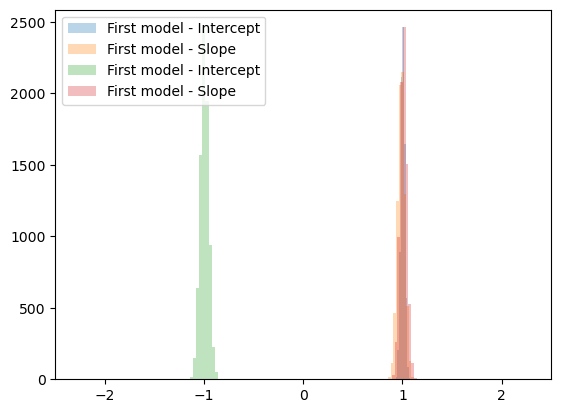

In [30]:
w1_sample = samples.posterior['w1'].to_numpy().reshape(-1,2,1)
w2_sample = samples.posterior['w2'].to_numpy().reshape(-1,2,1)
plt.hist(w1_sample[:,0],alpha=0.3, label='First model - Intercept')
plt.hist(w1_sample[:,1],alpha=0.3, label='First model - Slope')
plt.hist(w2_sample[:,0],alpha=0.3, label='First model - Intercept')
plt.hist(w2_sample[:,1],alpha=0.3, label='First model - Slope')
plt.xlim(-2.5,2.5)
plt.legend()
plt.show()

### Bayesian modelling with an incomplete dataset
Let's make some datapoints imperfect. Some datapoints will lose their y-values.

In [33]:
DF_missing = DF.copy()
idx = (DF_missing['y']>-0.3)&(DF_missing['y']<0.3)
DF_missing['y'][~idx]=np.nan
idx_na = DF_missing['y'].isna()
DF_missing

,x,y,z
0,-0.616961,NaN,-0.702592
1,0.244218,NaN,0.322829
2,-0.124545,NaN,-0.153278
3,0.570717,NaN,0.563955
4,0.559952,NaN,0.617799
...,...,...,...
95,0.005119,NaN,-0.339275
96,0.073756,NaN,-0.333031
97,0.638404,NaN,0.943660
98,-0.885769,NaN,-0.618673


In [36]:
print('The number of datapoints not having y values: ', DF_missing[~idx].shape[0])

The number of datapoints not having y values:  89


Let's first discard the imperfect datapoints and see if there's enough information in the dataset

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w1, w2]


Sampling 4 chains for 10_000 tune and 10_000 draw iterations (40_000 + 40_000 draws total) took 144 seconds.


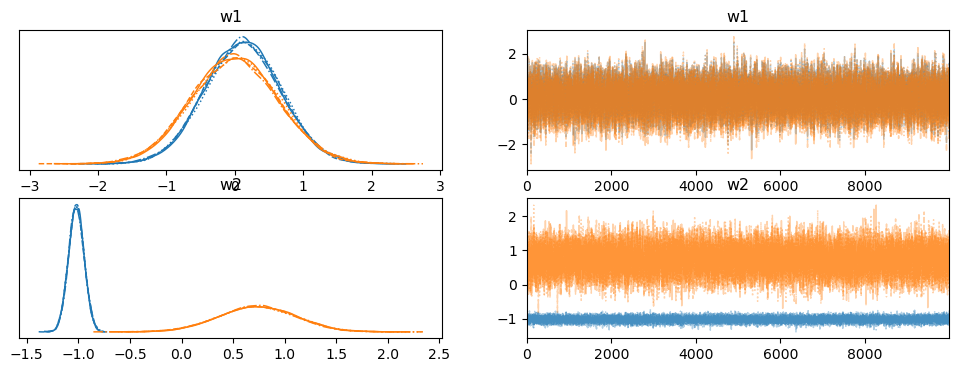

In [14]:
with pm.Model() as model2:
    # prior
    w1 = pm.Normal('w1', mu=0., sigma =10 , shape=2)
    w2 = pm.Normal('w2', mu=0., sigma =10 , shape=2)
    
    # likelihood
    mu1 = w1[0] + DF_missing['x'][~idx_na].values*w1[1]
    mu2 = w2[0] + DF_missing['y'][~idx_na].values*w2[1]
    y_like = pm.Normal("y", mu = mu1, sigma = 0.2, observed = DF_missing['y'][~idx_na].values)    
    z_like1 = pm.Normal("z_like1", mu = mu2, sigma = 0.2, observed = DF_missing['z'][~idx_na].values)

    # Bayesian inference - sampling
    samples2 = pm.sample(draws=2000, tune=2000, chains=4, cores=4)
    pm.plot_trace(samples2)

You can see that the marginalized posterior distributions are rather flat. For example, the posterior says the slope of the linear model for the x-y relationship can be -2, -1, 0, 1, or 2...i.e., very high level of uncertainty

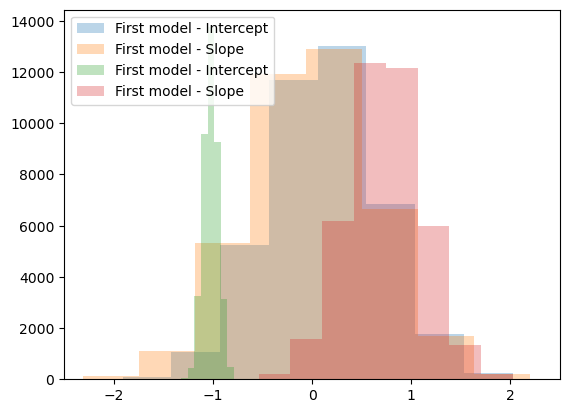

In [38]:
w1_sample = samples2.posterior['w1'].to_numpy().reshape(-1,2,1)
w2_sample = samples2.posterior['w2'].to_numpy().reshape(-1,2,1)
plt.hist(w1_sample[:,0],alpha=0.3, label='First model - Intercept')
plt.hist(w1_sample[:,1],alpha=0.3, label='First model - Slope')
plt.hist(w2_sample[:,0],alpha=0.3, label='First model - Intercept')
plt.hist(w2_sample[:,1],alpha=0.3, label='First model - Slope')
plt.xlim(-2.5,2.5)
plt.legend()
plt.show()

Instead of dropping the imperfect datapoints, you add 89 latent variables representing the missing y values. The model tries to estimate these latent vairables as well as the model parameters simultaniously.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w1, w2, y_latent]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 53 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


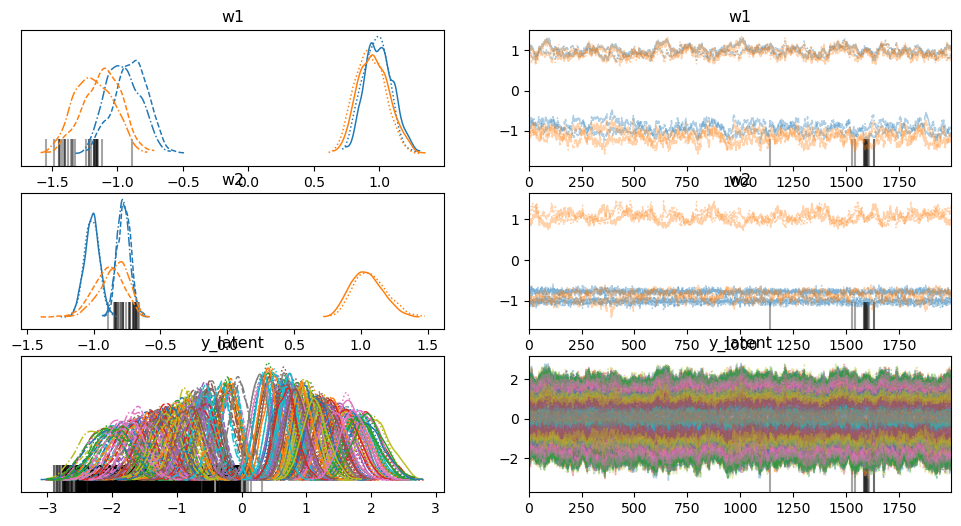

In [39]:
with pm.Model() as model3:
    # prior
    w1 = pm.Normal('w1', mu=0., sigma =10 , shape=2)
    w2 = pm.Normal('w2', mu=0., sigma =10 , shape=2)
    
    # likelihood for the perfect 11 data points
    mu1 = w1[0] + DF_missing['x'][~idx_na].values*w1[1]
    mu2 = w2[0] + DF_missing['y'][~idx_na].values*w2[1]
    y_like = pm.Normal("y", mu = mu1, sigma = 0.2, observed = DF_missing['y'][~idx_na].values)
    z_like1 = pm.Normal("z_like1", mu = mu2, sigma = 0.2, observed = DF_missing['z'][~idx_na].values)
    
    # 89 latent variables for the 89 y values
    y_latent = pm.Normal("y_latent", mu = w1[0] + DF_missing['x'][idx_na].values*w1[1], sigma = 0.2)
     
    # likelihood for the imperfect data points
    z_like2 = pm.Normal("z_like2", mu = w2[0] + y_latent*w2[1], sigma = 0.2, observed = DF_missing['z'][idx_na].values)
    
    # Bayesian inference - sampling
    samples3 = pm.sample(draws=2000, tune=2000, chains=4, cores=4)
    pm.plot_trace(samples3)

You can see that the posterior is much narrower than the one you got above although it is multimodal. This tells you that using the imperfect data points provides additional information.

(-2.5, 2.5)

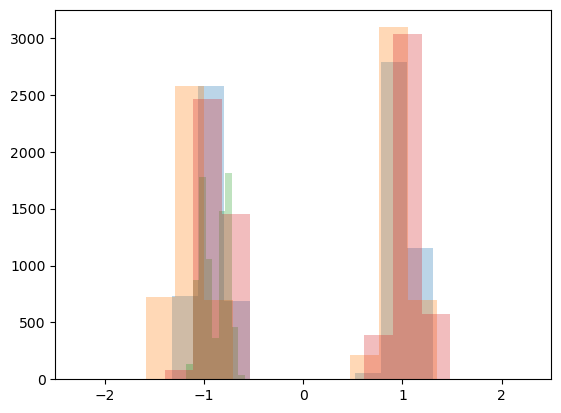

In [40]:
w1_sample = samples3.posterior['w1'].to_numpy().reshape(-1,2,1)
w2_sample = samples3.posterior['w2'].to_numpy().reshape(-1,2,1)
plt.hist(w1_sample[:,0],alpha=0.3)
plt.hist(w1_sample[:,1],alpha=0.3)
plt.hist(w2_sample[:,0],alpha=0.3)
plt.hist(w2_sample[:,1],alpha=0.3)
plt.xlim(-2.5,2.5)